# Notebook 05: Visualization Dashboard

**Purpose**: Generate all publication-quality figures from pipeline outputs

**Inputs**: All CSV files from Notebooks 01-04

**Outputs**: 8 publication figures (PNG + PDF formats)

**Execution time**: ~2-3 minutes

---

## Figure Plan

1. **Power Spectrum** - Already generated in Notebook 01
2. **Model Selection Curves** - Already generated in Notebook 02
3. **Optimal Model Fit** - Data vs prediction with train/test split
4. **Long-Term Extrapolation** - Predictions -50k to +100k CE
5. **Drift Analysis** - Error vs time with precession boundaries
6. **Residual Diagnostics** - 4-panel diagnostics
7. **294-Resonance** - Already generated in Notebook 04
8. **Model Comparison Table** - Summary comparison

In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import swisseph as swe
import pickle

from src.enoch import enoch_calendar_frame, merge_astronomic_data

from src.enoch_config import SWISS_EPH_PATH
swe.set_ephe_path(SWISS_EPH_PATH)
swe.set_jpl_file('de441.eph')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Setup complete")

✓ Setup complete


## Load All Data

In [2]:
# Load model comparison
model_comp_df = pd.read_csv('outputs/csvs/model_comparison.csv')

# Load optimal model
with open('outputs/models/optimal_model.pkl', 'rb') as f:
    analyzer = pickle.load(f)

# Load calendar data
YEAR_START = -12762
NUM_CYCLES = 100
TRAIN_END = 10000

e_df = enoch_calendar_frame(num_cycles=NUM_CYCLES)
a_df = merge_astronomic_data(e_df, YEAR_START, use_tt=True)

# Calculate solar year
a_df['solar_year'] = a_df['enoch_year'] + YEAR_START

day1_data = a_df[a_df.enoch_solar_doy == 1].copy()
day1_data = day1_data.sort_values('solar_year').reset_index(drop=True)

years = day1_data['solar_year'].values
ecliptic = day1_data['sun_ecliptic_longitude_neg'].values
valid_mask = ~np.isnan(ecliptic)
years = years[valid_mask]
ecliptic = ecliptic[valid_mask]

# Train/test split
train_mask = years <= TRAIN_END
test_mask = years > TRAIN_END

# Load extrapolation predictions
extrap_df = pd.read_csv('outputs/csvs/extrapolation_predictions.csv')

# Load drift analysis
drift_df = pd.read_csv('outputs/csvs/drift_analysis.csv')

# Load CV results
cv_df = pd.read_csv('outputs/csvs/cv_results.csv')

print("✓ All data loaded")

✓ All data loaded


## Figure 3: Optimal Model Fit (3-panel)

✓ Figure 3 saved: outputs/figures/fig_03_optimal_fit.png


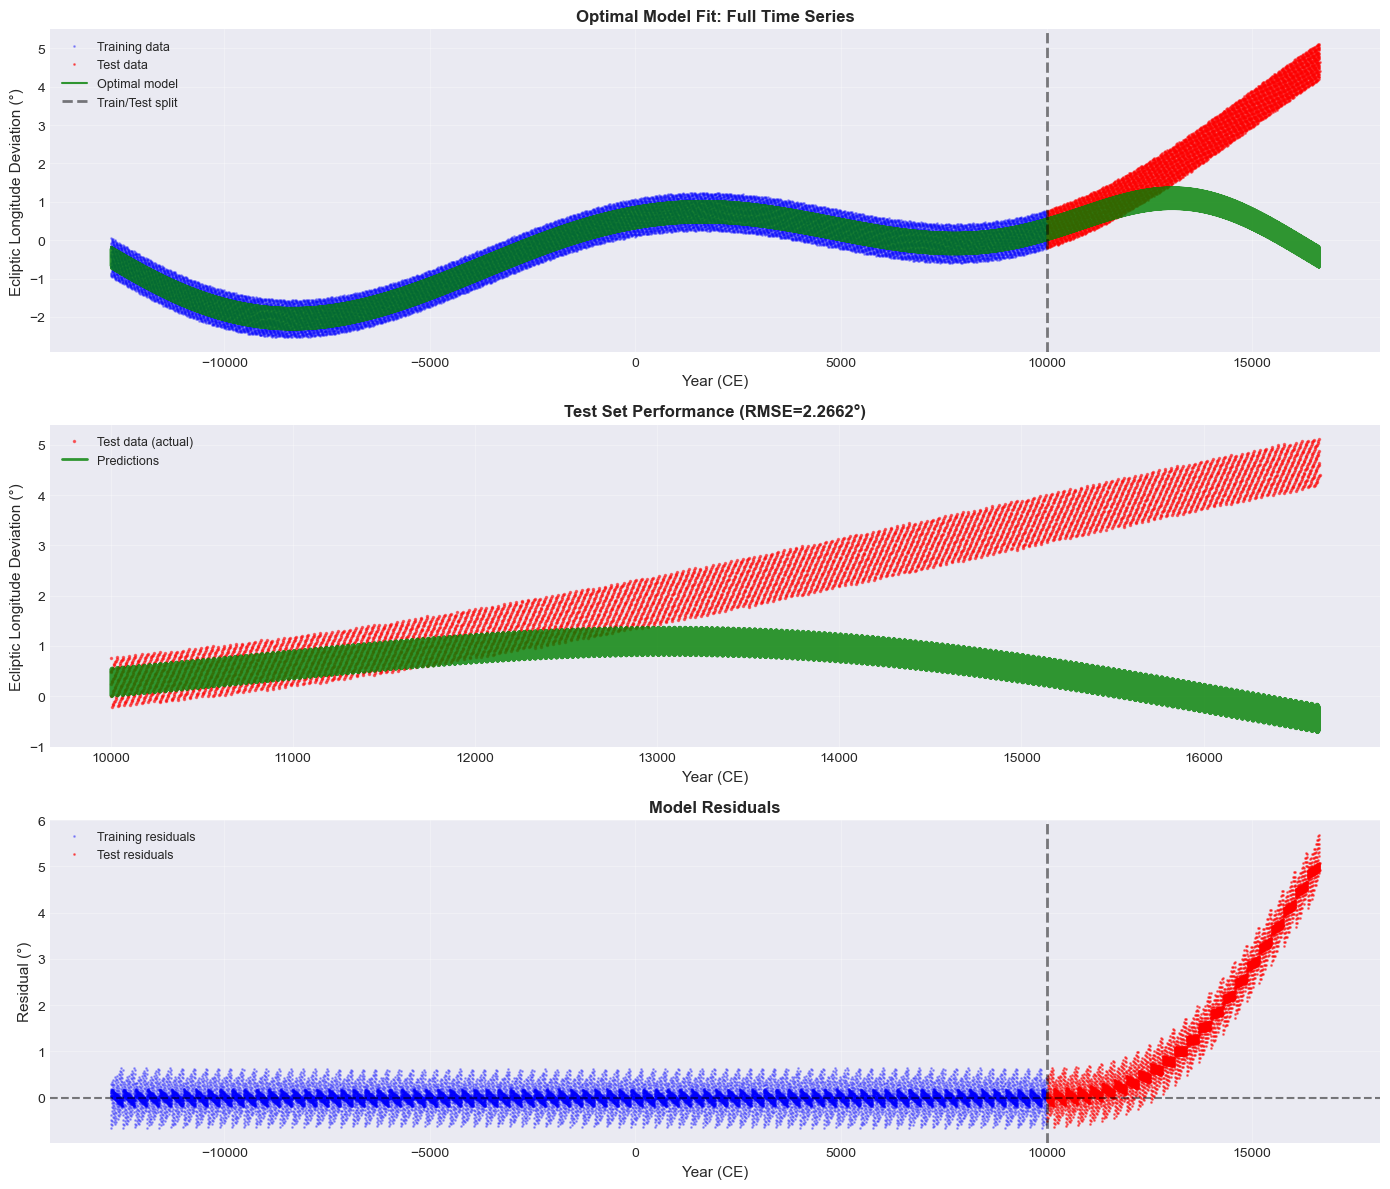

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Predictions
predictions = analyzer.predict(years)
residuals = ecliptic - predictions

# Panel A: Full time series
ax1 = axes[0]
ax1.plot(years[train_mask], ecliptic[train_mask], 'b.', alpha=0.3, markersize=2, label='Training data')
ax1.plot(years[test_mask], ecliptic[test_mask], 'r.', alpha=0.5, markersize=2, label='Test data')
ax1.plot(years, predictions, 'g-', linewidth=1.5, alpha=0.8, label='Optimal model')
ax1.axvline(TRAIN_END, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Train/Test split')
ax1.set_xlabel('Year (CE)', fontsize=11)
ax1.set_ylabel('Ecliptic Longitude Deviation (°)', fontsize=11)
ax1.set_title('Optimal Model Fit: Full Time Series', fontsize=12, weight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel B: Test set zoom
ax2 = axes[1]
ax2.plot(years[test_mask], ecliptic[test_mask], 'r.', alpha=0.5, markersize=3, label='Test data (actual)')
ax2.plot(years[test_mask], predictions[test_mask], 'g-', linewidth=2, alpha=0.8, label='Predictions')
test_rmse = np.sqrt(np.mean(residuals[test_mask]**2))
ax2.set_xlabel('Year (CE)', fontsize=11)
ax2.set_ylabel('Ecliptic Longitude Deviation (°)', fontsize=11)
ax2.set_title(f'Test Set Performance (RMSE={test_rmse:.4f}°)', fontsize=12, weight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Panel C: Residuals
ax3 = axes[2]
ax3.plot(years[train_mask], residuals[train_mask], 'b.', alpha=0.3, markersize=2, label='Training residuals')
ax3.plot(years[test_mask], residuals[test_mask], 'r.', alpha=0.5, markersize=2, label='Test residuals')
ax3.axhline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax3.axvline(TRAIN_END, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax3.set_xlabel('Year (CE)', fontsize=11)
ax3.set_ylabel('Residual (°)', fontsize=11)
ax3.set_title('Model Residuals', fontsize=12, weight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = 'outputs/figures/fig_03_optimal_fit.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.savefig(fig_path.replace('.png', '.pdf'), bbox_inches='tight')
print(f"✓ Figure 3 saved: {fig_path}")
plt.show()

## Figure 4: Long-Term Extrapolation

✓ Figure 4 saved: outputs/figures/fig_04_extrapolation.png


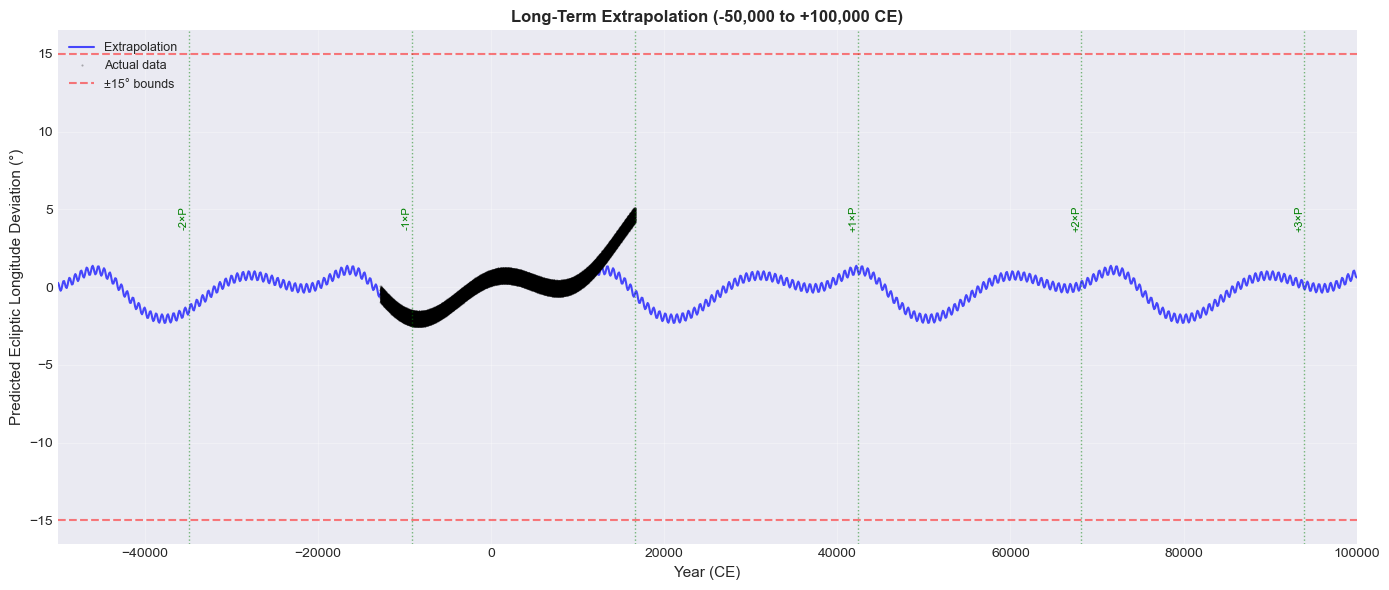

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

PRECESSION_PERIOD = 25772

# Plot extrapolation
ax.plot(extrap_df['year'], extrap_df['predicted_longitude'], 'b-', linewidth=1.5, alpha=0.7, label='Extrapolation')

# Overlay actual data where available
ax.plot(years, ecliptic, 'k.', markersize=1, alpha=0.3, label='Actual data')

# Mark precession boundaries
data_end = years.max()
for i in range(-2, 4):
    boundary = data_end + i * PRECESSION_PERIOD
    if boundary >= extrap_df['year'].min() and boundary <= extrap_df['year'].max():
        ax.axvline(boundary, color='green', linestyle=':', linewidth=1, alpha=0.5)
        if i != 0:
            ax.text(boundary, ax.get_ylim()[1]*0.95, f'{i:+d}×P',
                   rotation=90, va='top', ha='right', fontsize=8, color='green')

# Mark ±15° bounds
ax.axhline(15, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='±15° bounds')
ax.axhline(-15, color='red', linestyle='--', linewidth=1.5, alpha=0.5)

ax.set_xlabel('Year (CE)', fontsize=11)
ax.set_ylabel('Predicted Ecliptic Longitude Deviation (°)', fontsize=11)
ax.set_title('Long-Term Extrapolation (-50,000 to +100,000 CE)', fontsize=12, weight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(extrap_df['year'].min(), extrap_df['year'].max())

plt.tight_layout()
fig_path = 'outputs/figures/fig_04_extrapolation.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.savefig(fig_path.replace('.png', '.pdf'), bbox_inches='tight')
print(f"✓ Figure 4 saved: {fig_path}")
plt.show()

## Figure 5: Drift Analysis (2-panel)

✓ Figure 5 saved: outputs/figures/fig_05_drift.png


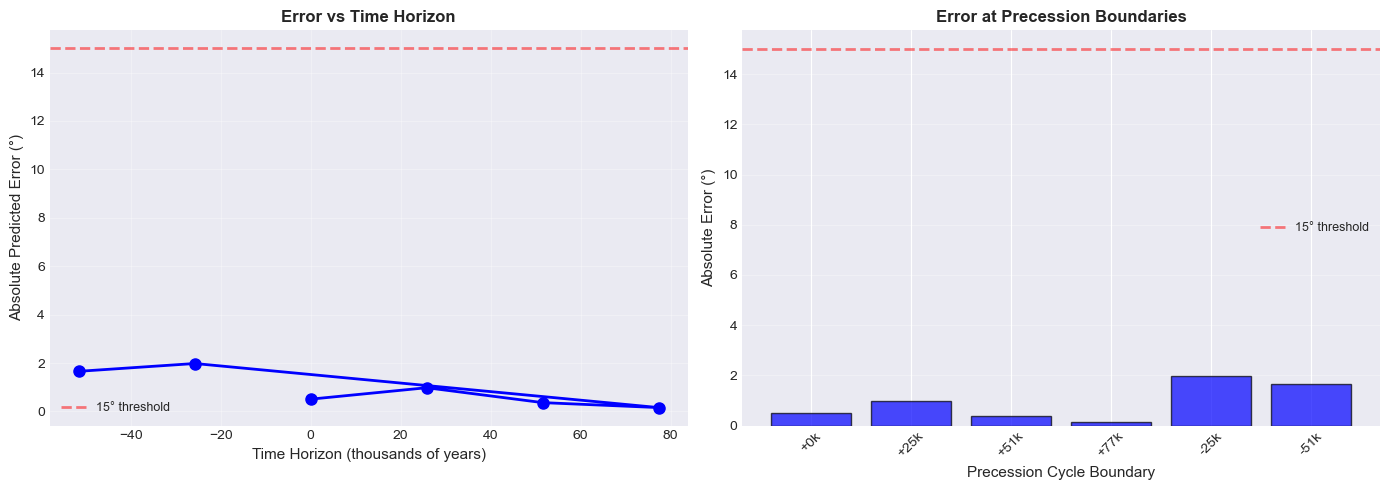

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Error vs time horizon
ax1 = axes[0]
ax1.plot(drift_df['time_horizon']/1000, drift_df['abs_predicted_value'], 
        'bo-', linewidth=2, markersize=8)
ax1.axhline(15, color='red', linestyle='--', linewidth=2, alpha=0.5, label='15° threshold')
ax1.set_xlabel('Time Horizon (thousands of years)', fontsize=11)
ax1.set_ylabel('Absolute Predicted Error (°)', fontsize=11)
ax1.set_title('Error vs Time Horizon', fontsize=12, weight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel B: Error at precession boundaries
ax2 = axes[1]
colors = ['blue' if abs(x) < 15 else 'red' for x in drift_df['abs_predicted_value']]
ax2.bar(range(len(drift_df)), drift_df['abs_predicted_value'], color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(15, color='red', linestyle='--', linewidth=2, alpha=0.5, label='15° threshold')
ax2.set_xticks(range(len(drift_df)))
ax2.set_xticklabels([f"{int(h/1000):+d}k" for h in drift_df['time_horizon']], rotation=45)
ax2.set_xlabel('Precession Cycle Boundary', fontsize=11)
ax2.set_ylabel('Absolute Error (°)', fontsize=11)
ax2.set_title('Error at Precession Boundaries', fontsize=12, weight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = 'outputs/figures/fig_05_drift.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.savefig(fig_path.replace('.png', '.pdf'), bbox_inches='tight')
print(f"✓ Figure 5 saved: {fig_path}")
plt.show()

## Figure 6: Residual Diagnostics (4-panel)

✓ Figure 6 saved: outputs/figures/fig_06_residuals.png


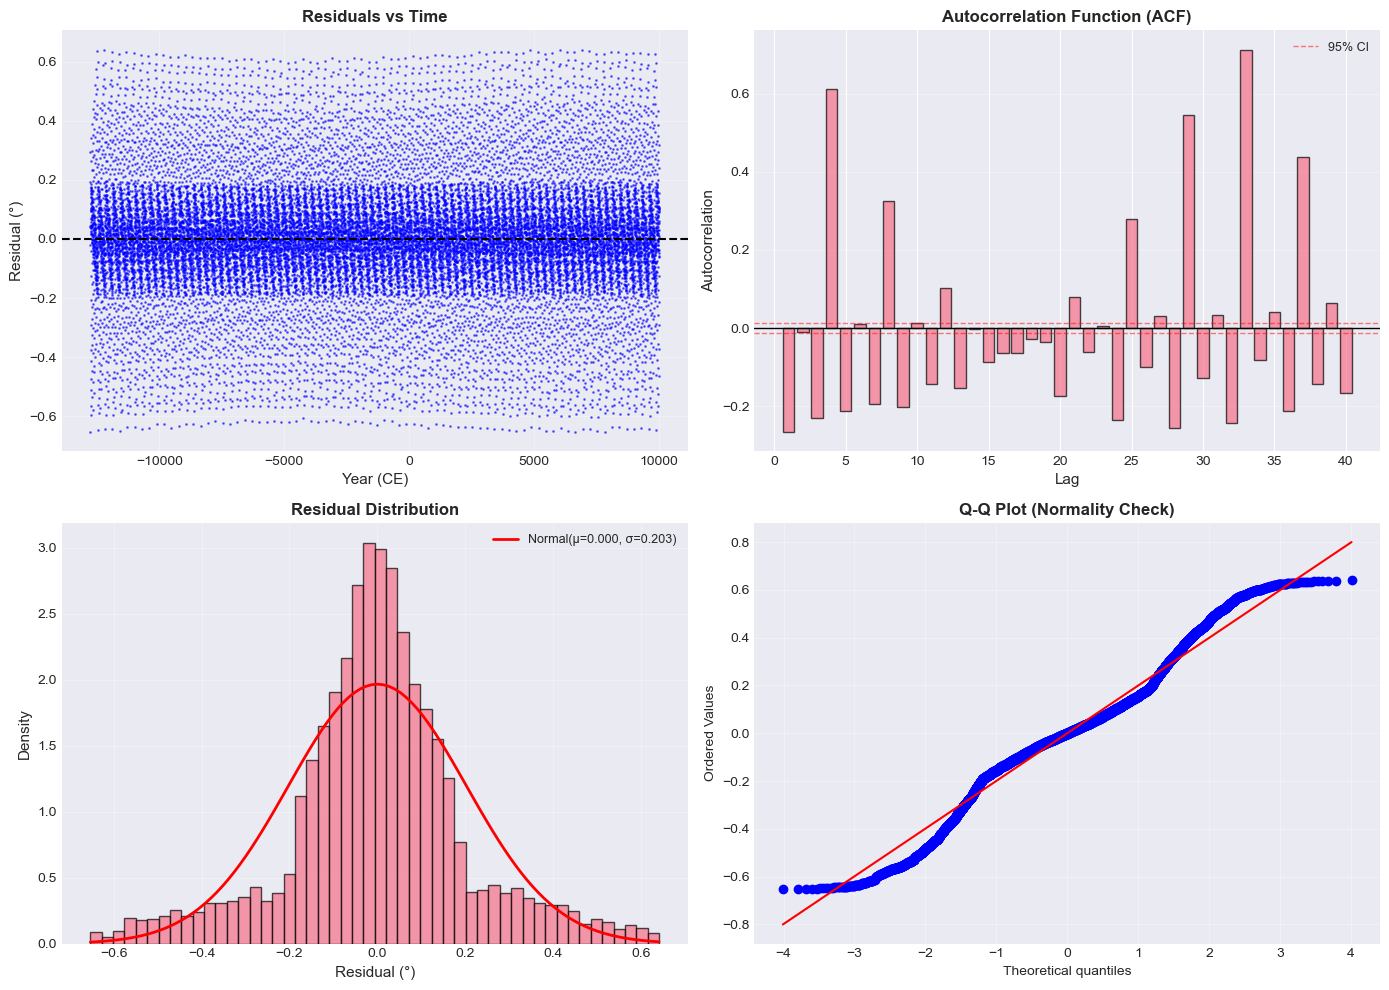

In [6]:
from scipy import stats as scipy_stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calculate residuals for the analyzer's training data
fitted_values = analyzer.predict(analyzer.years)
train_residuals = analyzer.values - fitted_values

# Panel A: Residuals vs time
ax1 = axes[0, 0]
ax1.plot(analyzer.years, train_residuals, 'b.', alpha=0.5, markersize=2)
ax1.axhline(0, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Year (CE)', fontsize=11)
ax1.set_ylabel('Residual (°)', fontsize=11)
ax1.set_title('Residuals vs Time', fontsize=12, weight='bold')
ax1.grid(True, alpha=0.3)

# Panel B: ACF plot
ax2 = axes[0, 1]
max_lag = 40
acf_values = [np.corrcoef(train_residuals[:-k], train_residuals[k:])[0, 1] for k in range(1, max_lag+1)]
ax2.bar(range(1, max_lag+1), acf_values, alpha=0.7, edgecolor='black')
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.axhline(1.96/np.sqrt(len(train_residuals)), color='red', linestyle='--', linewidth=1, alpha=0.5, label='95% CI')
ax2.axhline(-1.96/np.sqrt(len(train_residuals)), color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Lag', fontsize=11)
ax2.set_ylabel('Autocorrelation', fontsize=11)
ax2.set_title('Autocorrelation Function (ACF)', fontsize=12, weight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Panel C: Histogram + Q-Q plot
ax3 = axes[1, 0]
ax3.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black', density=True)
mu, sigma = train_residuals.mean(), train_residuals.std()
x = np.linspace(train_residuals.min(), train_residuals.max(), 100)
ax3.plot(x, scipy_stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label=f'Normal(μ={mu:.3f}, σ={sigma:.3f})')
ax3.set_xlabel('Residual (°)', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('Residual Distribution', fontsize=12, weight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Panel D: Q-Q plot
ax4 = axes[1, 1]
scipy_stats.probplot(train_residuals, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Normality Check)', fontsize=12, weight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = 'outputs/figures/fig_06_residuals.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.savefig(fig_path.replace('.png', '.pdf'), bbox_inches='tight')
print(f"✓ Figure 6 saved: {fig_path}")
plt.show()

## Figure 8: Model Comparison Table

In [7]:
# Create publication summary table
optimal_row = model_comp_df.iloc[model_comp_df['bic'].idxmin()]
optimal_n = int(optimal_row['n_harmonics'])

comparison_rows = []

# Add specific models for comparison
for n in [3, 5, optimal_n, 11]:
    if n in model_comp_df['n_harmonics'].values:
        row = model_comp_df[model_comp_df['n_harmonics'] == n].iloc[0]
        status = 'Optimal' if n == optimal_n else ('Underfit' if n < optimal_n else 'Overfit')
        
        comparison_rows.append({
            'Model': f'{n}-harmonic',
            'n_harmonics': n,
            'In-Sample R²': row['in_sample_r2'],
            'Test RMSE': row['test_rmse'],
            'Extrap 50k RMSE': row.get('extrap_50k_rmse', np.nan),
            'BIC': row['bic'],
            'Status': status
        })

pub_table = pd.DataFrame(comparison_rows)
pub_table.to_csv('outputs/csvs/publication_summary_table.csv', index=False)

print("Model Comparison Table:")
print("="*90)
print(pub_table.to_string(index=False))
print("="*90)

print(f"\n✓ Publication table saved: outputs/csvs/publication_summary_table.csv")

Model Comparison Table:
      Model  n_harmonics  In-Sample R²  Test RMSE  Extrap 50k RMSE           BIC   Status
 3-harmonic            3      0.917199   2.447537         0.954490 -56969.460973 Underfit
 5-harmonic            5      0.917350   2.303941         0.981721 -56970.729115 Underfit
 7-harmonic            7      0.958230   2.266176         1.009800 -72465.392759  Optimal
11-harmonic           11      0.958230   2.133161         1.073402 -72385.498397  Overfit

✓ Publication table saved: outputs/csvs/publication_summary_table.csv


## Summary

In [8]:
print("="*70)
print("VISUALIZATION DASHBOARD COMPLETE")
print("="*70)

print(f"\nGenerated Figures:")
print(f"  Fig 01: Power Spectrum (from Notebook 01)")
print(f"  Fig 02: Model Selection Curves (from Notebook 02)")
print(f"  Fig 03: Optimal Model Fit ✓")
print(f"  Fig 04: Long-Term Extrapolation ✓")
print(f"  Fig 05: Drift Analysis ✓")
print(f"  Fig 06: Residual Diagnostics ✓")
print(f"  Fig 07: 294-Resonance Heatmap (from Notebook 04)")
print(f"  Fig 08: Model Comparison Table ✓")

print(f"\nAll figures saved in both PNG and PDF formats")
print(f"Location: outputs/figures/")

print("\n" + "="*70)
print("✓ Notebook 05 complete - PIPELINE FINISHED")
print("="*70)
print(f"\nAll 5 notebooks successfully executed.")
print(f"Results ready for manuscript integration.")

VISUALIZATION DASHBOARD COMPLETE

Generated Figures:
  Fig 01: Power Spectrum (from Notebook 01)
  Fig 02: Model Selection Curves (from Notebook 02)
  Fig 03: Optimal Model Fit ✓
  Fig 04: Long-Term Extrapolation ✓
  Fig 05: Drift Analysis ✓
  Fig 06: Residual Diagnostics ✓
  Fig 07: 294-Resonance Heatmap (from Notebook 04)
  Fig 08: Model Comparison Table ✓

All figures saved in both PNG and PDF formats
Location: outputs/figures/

✓ Notebook 05 complete - PIPELINE FINISHED

All 5 notebooks successfully executed.
Results ready for manuscript integration.
